In [1]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph

maup.progress.enabled = True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# state = Ohio
state_ab = "oh"

## Data
1. Download all the data in directory "tn_data"
2. Extract them all

In [4]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
cd_data = "./{}{}_cong_adopted_2022/oh_cong_adopted_2022.shp".format(data_folder, state_ab)
send_data = "./{}{}_sldu_adopted_2023/2024-2032-sd-shapefile/Corrected Sept 29 2023 Unified Bipartisan Redistricting Plan SD SHP.shp".format(data_folder, state_ab)
hdist_data = "./{}{}_sldl_adopted_2023/2024-2032-hd-shapefile/Corrected Sept 29 2023 Unified Bipartisan Redistricting Plan HD SHP.shp".format(data_folder, state_ab)

In [5]:
def do_smart_repair(df):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df)
    if maup.doctor(df):
        print('smart_repair successful')
            
        # change it back to this UTM for this data
        df = df.to_crs('EPSG:4269')
    else:
        raise Exception('smart_repair failed')
    return df

In [6]:
def add_district(dist_df, dist_name, election_df, col_name):
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)
    
    election_df = gpd.GeoDataFrame(election_df, crs="EPSG:4269")
    
    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]
    
    return election_df

In [7]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [8]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [9]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [10]:
def add_vest(vest, df, year, population, start_col):    
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs="EPSG:4269")
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)

    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated

    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs="EPSG:4269")
    df = gpd.GeoDataFrame(df, crs="EPSG:4269")
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    
    # check if population agrees
    check_population(population, df)
        
    return df

### Read the census data

In [11]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)

In [12]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [13]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')

In [14]:
maup.doctor(population_df)

100%|██████████| 276428/276428 [04:07<00:00, 1116.42it/s]


True

In [15]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['P0020005'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['P0020006'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['P0020007'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['P0020008'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['P0020009'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['P0020010'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['P0020011'], 1)

In [16]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
                    'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
                    'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
                                        'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [17]:
population_df.rename(columns=rename_dict, inplace = True)

In [18]:
cong_df = gpd.read_file(cd_data)
if maup.doctor(cong_df) != True:
    cong_df = do_smart_repair(cong_df)

100%|██████████| 15/15 [00:00<00:00, 79.54it/s]


## Read the vest 20 data

Now using it as a "base pricinct"

In [19]:
def add_vest_base(vest, start_col, year):
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs="EPSG:4269")
    
    return vest

## Check if vest20 can be used as base

In [20]:
vest20 = gpd.read_file(vest20_data)
if maup.doctor(vest20) != True:
    vest20 = do_smart_repair(vest20)

100%|██████████| 8941/8941 [00:11<00:00, 801.65it/s] 


There are 2 overlaps.
There are 6 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|██████████| 10804/10804 [00:07<00:00, 1369.24it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


100%|██████████| 8941/8941 [00:11<00:00, 805.81it/s] 


smart_repair successful


In [21]:
vest20.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20', 'NAME20',
       'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW', 'geometry'],
      dtype='object')

In [22]:
start_col = 6
vest_base_data = vest20
year = '20'

In [23]:
vest_base = add_vest_base(vest_base_data, start_col, year)

In [24]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|██████████| 8941/8941 [00:48<00:00, 183.55it/s]


In [25]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [26]:
election_df = gpd.GeoDataFrame(vest_base, crs="EPSG:4269")

In [27]:
election_df.columns

Index(['COUNTYFP20', 'GEOID20', 'NAME20', 'PRE20D', 'PRE20O', 'PRE20R',
       'PRECINCT20', 'STATEFP20', 'VTDST20', 'geometry', 'TOTPOP', 'HISP',
       'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER',
       'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI',
       'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP',
       'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP'],
      dtype='object')

## Check if population agrees

In [28]:
pd.DataFrame({
    'pop_col': pop_col,
    'population_df': population_df[pop_col].sum(), 
    'vest_base': vest_base[pop_col].sum(),
    'equal': [x == y for x, y in zip(population_df[pop_col].sum(), vest_base[pop_col].sum())]
})

,pop_col,population_df,vest_base,equal
TOTPOP,TOTPOP,11799448,11799448,True
HISP,HISP,521308,521308,True
NH_WHITE,NH_WHITE,8954135,8954135,True
NH_BLACK,NH_BLACK,1457180,1457180,True
NH_AMIN,NH_AMIN,18949,18949,True
NH_ASIAN,NH_ASIAN,296604,296604,True
NH_NHPI,NH_NHPI,4493,4493,True
NH_OTHER,NH_OTHER,45217,45217,True
NH_2MORE,NH_2MORE,501562,501562,True
H_WHITE,H_WHITE,126553,126553,True


## Add more vest data

In [29]:
vest18 = gpd.read_file(vest18_data)
vest16 = gpd.read_file(vest16_data)

In [30]:
vest18.columns

Index(['STATEFP18', 'COUNTYFP18', 'VTDST18', 'PRECINCT18', 'GEOID18', 'NAME18',
       'G18USSRREN', 'G18USSDBRO', 'G18GOVRDEW', 'G18GOVDCOR', 'G18GOVLIRV',
       'G18GOVGGAD', 'G18ATGRYOS', 'G18ATGDDET', 'G18AUDRFAB', 'G18AUDDSPA',
       'G18AUDLCOO', 'G18SOSRLAR', 'G18SOSDCLY', 'G18SOSLNAN', 'G18TRERSPR',
       'G18TREDRIC', 'geometry'],
      dtype='object')

In [31]:
vest16.columns

Index(['STATEFP16', 'COUNTYFP16', 'VTDST16', 'PRECINCT16', 'GEOID16', 'NAME16',
       'G16PRERTRU', 'G16PREDCLI', 'G16PRELJOH', 'G16PREGSTE', 'G16PREIDUN',
       'G16USSRPOR', 'G16USSDSTR', 'G16USSGDEM', 'G16USSICON', 'G16USSIRUP',
       'geometry'],
      dtype='object')

In [32]:
# check the result here
election_df = add_vest(vest18, election_df, '18', population_df, start_col)

100%|██████████| 8912/8912 [00:12<00:00, 699.68it/s]


There are 5 overlaps.
There are 5 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|██████████| 10770/10770 [00:07<00:00, 1391.88it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


100%|██████████| 8912/8912 [00:11<00:00, 801.17it/s] 


smart_repair successful


100%|██████████| 8941/8941 [00:45<00:00, 198.03it/s]


population agrees


In [33]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'ATG18D', 'ATG18R', 'AUD18D',
       'AUD18O', 'AUD18R', 'BVAP', 'COUNTYFP20', 'GEOID20', 'GOV18D', 'GOV18O',
       'GOV18R', 'HISP', 'HVAP', 'H_2MORE', 'H_AMIN', 'H_ASIAN', 'H_BLACK',
       'H_NHPI', 'H_OTHER', 'H_WHITE', 'NAME20', 'NHPIVAP', 'NH_2MORE',
       'NH_AMIN', 'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE',
       'OTHERVAP', 'PRE20D', 'PRE20O', 'PRE20R', 'PRECINCT20', 'SOS18D',
       'SOS18O', 'SOS18R', 'STATEFP20', 'TOTPOP', 'TRE18D', 'TRE18R', 'USS18D',
       'USS18R', 'VAP', 'VTDST20', 'WVAP', 'geometry'],
      dtype='object')

In [34]:
election_df = add_vest(vest16, election_df, '16', population_df, start_col)

100%|██████████| 8895/8895 [00:11<00:00, 773.78it/s] 


There are 7 overlaps.
There are 9 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|██████████| 10749/10749 [00:06<00:00, 1541.75it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


100%|██████████| 8895/8895 [00:11<00:00, 805.13it/s] 


smart_repair successful


100%|██████████| 8941/8941 [00:44<00:00, 199.57it/s]


population agrees


##  Add the district data

In [35]:
send = gpd.read_file(send_data)
hdist = gpd.read_file(hdist_data)

In [36]:
cong_df.head()

,CONG_DIST,geometry
0,01,"POLYGON ((-84.60438 39.07366, -84.60585 39.073..."
1,02,"POLYGON ((-82.54392 38.40366, -82.54403 38.403..."
2,03,"POLYGON ((-82.95870 39.90133, -82.95939 39.901..."
3,04,"POLYGON ((-83.51179 40.04372, -83.51197 40.042..."
4,05,"POLYGON ((-84.64352 40.35180, -84.64391 40.351..."


In [37]:
election_df = add_district(cong_df, "CD", election_df, "CONG_DIST")

100%|██████████| 15/15 [00:03<00:00,  4.97it/s]


In [38]:
send.head()

,DISTRICT,geometry
0,1,"POLYGON ((-83.87520 40.36085, -83.87754 40.361..."
1,10,"POLYGON ((-83.87849 39.24803, -83.88421 39.248..."
2,11,"POLYGON ((-83.40384 41.74265, -83.39790 41.747..."
3,12,"POLYGON ((-83.86425 40.03044, -83.86466 40.030..."
4,13,"POLYGON ((-81.92044 41.27538, -81.92047 41.275..."


In [41]:
send.to_crs('EPSG:4269', inplace=True)

In [42]:
election_df = add_district(send, "SEND", election_df, "DISTRICT")

100%|██████████| 33/33 [00:03<00:00,  9.99it/s]


In [43]:
hdist.head()

,DISTRICT,geometry
0,1,"POLYGON ((-82.90452 39.96737, -82.90473 39.964..."
1,10,"POLYGON ((-83.15459 39.88271, -83.15468 39.882..."
2,11,"POLYGON ((-83.23703 39.96652, -83.23726 39.966..."
3,12,"POLYGON ((-82.87030 39.79741, -82.87013 39.797..."
4,13,"POLYGON ((-81.80642 41.49958, -81.80242 41.500..."


In [44]:
hdist = hdist.to_crs("EPSG:4269")
election_df = add_district(hdist, "HDIST", election_df, "DISTRICT")

100%|██████████| 99/99 [00:04<00:00, 20.31it/s]


In [45]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'ATG18D', 'ATG18R', 'AUD18D',
       'AUD18O', 'AUD18R', 'BVAP', 'COUNTYFP20', 'GEOID20', 'GOV18D', 'GOV18O',
       'GOV18R', 'HISP', 'HVAP', 'H_2MORE', 'H_AMIN', 'H_ASIAN', 'H_BLACK',
       'H_NHPI', 'H_OTHER', 'H_WHITE', 'NAME20', 'NHPIVAP', 'NH_2MORE',
       'NH_AMIN', 'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE',
       'OTHERVAP', 'PRE16D', 'PRE16O', 'PRE16R', 'PRE20D', 'PRE20O', 'PRE20R',
       'PRECINCT20', 'SOS18D', 'SOS18O', 'SOS18R', 'STATEFP20', 'TOTPOP',
       'TRE18D', 'TRE18R', 'USS16D', 'USS16O', 'USS16R', 'USS18D', 'USS18R',
       'VAP', 'VTDST20', 'WVAP', 'geometry', 'CD', 'SEND', 'HDIST'],
      dtype='object')

### Put the base precinct year after the precinct information column

In [46]:
base_columns = {}
if 'COUNTYFP' + year not in election_df.columns:
    base_columns = {
        'STATEFP':'STATEFP'+year,
        'COUNTYFP':'COUNTYFP'+year,
        'VTDST':'VTDST'+year,
        'PRECINCT':'COUNTY'+year,
        'GEOID':'GEOID'+year,
        'NAME':'NAME'+year}
election_df.rename(columns=base_columns, inplace = True)

In [47]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'ATG18D', 'ATG18R', 'AUD18D',
       'AUD18O', 'AUD18R', 'BVAP', 'COUNTYFP20', 'GEOID20', 'GOV18D', 'GOV18O',
       'GOV18R', 'HISP', 'HVAP', 'H_2MORE', 'H_AMIN', 'H_ASIAN', 'H_BLACK',
       'H_NHPI', 'H_OTHER', 'H_WHITE', 'NAME20', 'NHPIVAP', 'NH_2MORE',
       'NH_AMIN', 'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE',
       'OTHERVAP', 'PRE16D', 'PRE16O', 'PRE16R', 'PRE20D', 'PRE20O', 'PRE20R',
       'PRECINCT20', 'SOS18D', 'SOS18O', 'SOS18R', 'STATEFP20', 'TOTPOP',
       'TRE18D', 'TRE18R', 'USS16D', 'USS16O', 'USS16R', 'USS18D', 'USS18R',
       'VAP', 'VTDST20', 'WVAP', 'geometry', 'CD', 'SEND', 'HDIST'],
      dtype='object')

In [48]:
# reorder the columns
fixed_columns = [
    'STATEFP'+year,
    'COUNTYFP'+year,
    'VTDST'+year,
    'PRECINCT'+year,
    'GEOID'+year,
    'NAME'+year,
    'CD',
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [49]:
import os

# store the result in directory "il"
directory = "./{}".format(state_ab)
if not os.path.exists(directory):
    os.makedirs(directory)

shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
geojson_path = './{}/{}.geojson'.format(state_ab, state_ab)
json_path = "./{}/{}.json".format(state_ab, state_ab)

# Check if the shapefile or geojson file already exists
if os.path.exists(shapefile_path):
    os.remove(shapefile_path)
if os.path.exists(geojson_path):
    os.remove(geojson_path)

election_df.to_file(shapefile_path)
election_df.to_file(geojson_path, driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file(shapefile_path, ignore_errors=True)
graph.to_json(json_path)

<Axes: >

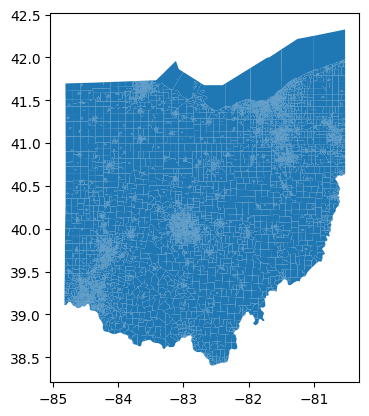

In [50]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()